# Predicting a Pokemon's Type using only Two Stats

In [1]:
# First import all the stuff
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Here I'll be seeing whether it's possible a Pokemon's primary type using only two of its stats. First I'll try to predict the type using all of the stats to get a good baseline to compare it too.

In [2]:
# Read in the data. This data is just bare minimum of each Pokemon's stats and type.
pokemon = pd.read_csv('Pokemon.csv')
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


It looks like we can set the '#' column as the index itself. Additionally, we can make the Type 1 and Type 2 into factor columns rather than as simple objects.

In [3]:
# Set the index to the '#' column and drop it
pokemon = pokemon.set_index(pokemon['#'])
pokemon.drop('#', axis=1, inplace=True)
# Change the Type columns to factors
pokemon['Type 1'] = pd.Categorical(pokemon['Type 1'])
pokemon['Type 2'] = pd.Categorical(pokemon['Type 2'])
pokemon.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


## Setting the Colors
Now, before we start our analysis, I would like to set the colors for each type. This is purely for plotting purposes. If you're a Pokemon fan, seeing an Ice type coded as green is unsightly. Thus, I'll be scraping the colors from the web and set it as a new column in the table.

In [4]:
# import stuff required for scraping
import requests
from bs4 import BeautifulSoup
link = 'http://www.epidemicjohto.com/t882-type-colors-hex-colors'
root = BeautifulSoup(requests.get(link).content, 'lxml')
pTab = root.find('table', class_='itable')
typeColors = {}
for typeCol in pTab.find_all('font'):
    typeColors[typeCol.text] = typeCol['color']
pokemon['Type Color'] = pokemon['Type 1'].apply(lambda x: typeColors[x])
pokemon.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type Color
#,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,#7AC74C
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,#7AC74C
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,#7AC74C
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,#7AC74C
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,#EE8130


## Predicting to Two Types
Let's start small. Instead of going straight to predicting all 18 types, let's start with just 2. I'll be choosing Grass and Ice (two of my favorites). Note that some pokemon are dual Grass and Ice. In this case, I'll be predicting the primary type a.k.a Type 1. Hence, I won't be needing Type 2. The two types I'll be choosing is the Attack and Defense. 

In [5]:
pokemonMod = pokemon.loc[pokemon['Type 1'].isin(['Grass', 'Ice'])]
pokemonMod = pokemonMod[['Type 1', 'Attack', 'Defense', 'Type Color']]
pokemonMod.head()

,Type 1,Attack,Defense,Type Color
#,,,,
1,Grass,49,49,#7AC74C
2,Grass,62,63,#7AC74C
3,Grass,82,83,#7AC74C
3,Grass,100,123,#7AC74C
43,Grass,50,55,#7AC74C


<module 'matplotlib.pyplot' from 'c:\\users\\mughi\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

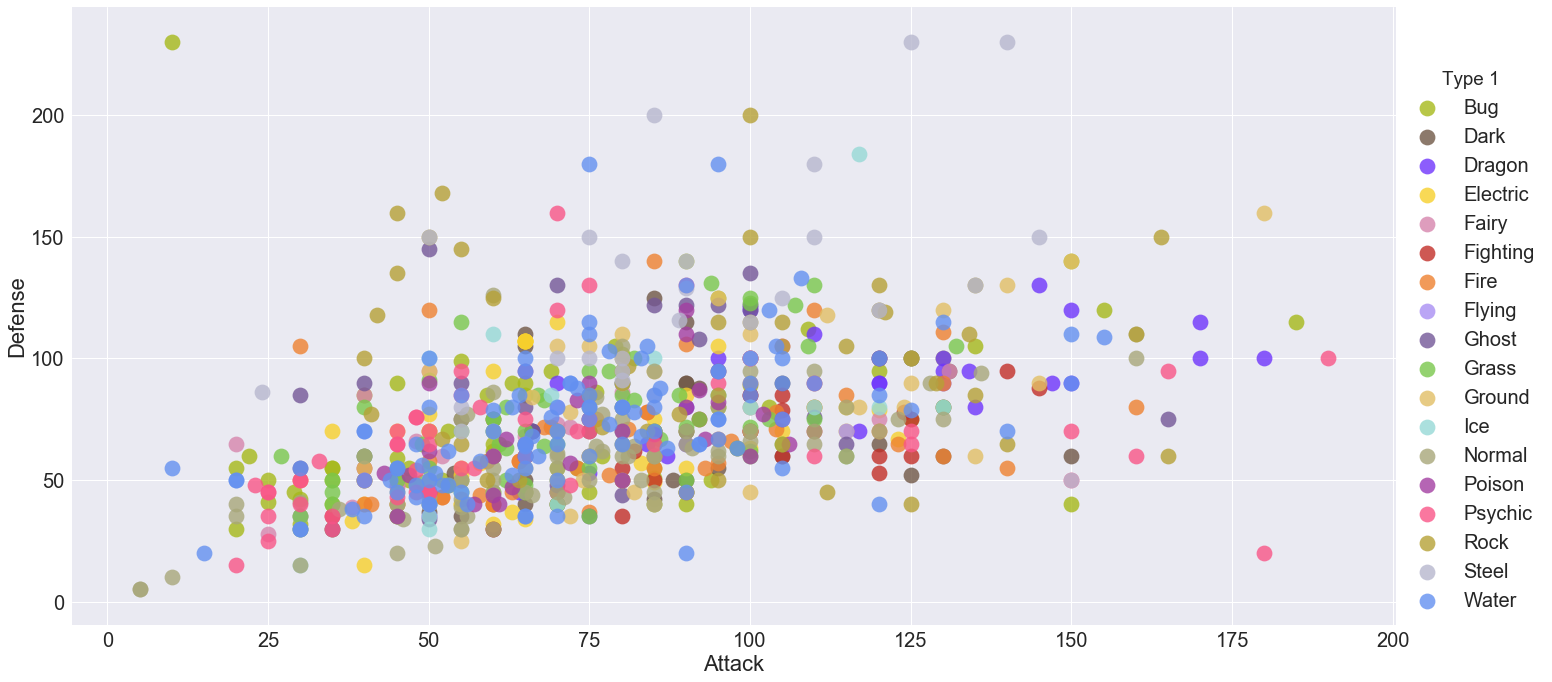

In [6]:
sns.set(font_scale=2)
sns.lmplot(x='Attack', y='Defense', hue='Type 1', palette=typeColors, fit_reg=False, 
           data=pokemon, size=10, aspect=2, 
           scatter_kws={'s': 250})
plt

Hmmm.... it doesn't look like there is a clear cut clustering of the points...Also it seems that there are a lot more Pokemon whose primary type is Grass than Ice. In any case, let's test out two classification methods: Logistic Regression and K-Means Clustering.

### Logistic Regression

In [7]:
# Import the stuff
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [8]:
# Split data into X and Y
X = pokemonMod.drop(['Type Color', 'Type 1'], axis=1)
Y = np.ravel(pokemonMod['Type 1'])

In [9]:
# Finally input into our model and check our score
logMod = LogisticRegression()
logMod.fit(X, Y)
logMod.score(X, Y)

0.74468085106382975

So it looks like we're getting around 74% accuracy. Let's compare to the best-case null error rate. There are more Grass types so if we guessed everything was a Grass type:

In [10]:
len(Y[Y == 'Grass']) / len(Y)

0.7446808510638298

Okay....so it doesn't look like the model is doing anything. Let's split our data into training and testing and see how well it does.

In [11]:
XTrain, XTest, YTrain, YTest = train_test_split(X, Y)
logMod2 = LogisticRegression()
logMod2.fit(XTrain, YTrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
predictions = logMod2.predict(XTest)
print(metrics.accuracy_score(YTest, predictions))

0.708333333333


So we only did a half of percentage point, which is only neglibile. Let's see probabilities as opposed to straight-up predictions.

In [13]:
probs = logMod2.predict_proba(XTest)
probs

array([[ 0.78775857,  0.21224143],
       [ 0.73287071,  0.26712929],
       [ 0.74500594,  0.25499406],
       [ 0.74762805,  0.25237195],
       [ 0.78191833,  0.21808167],
       [ 0.74186967,  0.25813033],
       [ 0.71353362,  0.28646638],
       [ 0.80944999,  0.19055001],
       [ 0.73481784,  0.26518216],
       [ 0.73380044,  0.26619956],
       [ 0.76779405,  0.23220595],
       [ 0.6967956 ,  0.3032044 ],
       [ 0.76872247,  0.23127753],
       [ 0.83034644,  0.16965356],
       [ 0.75382763,  0.24617237],
       [ 0.72219373,  0.27780627],
       [ 0.70631663,  0.29368337],
       [ 0.79046673,  0.20953327],
       [ 0.76592941,  0.23407059],
       [ 0.79695543,  0.20304457],
       [ 0.76686303,  0.23313697],
       [ 0.7943569 ,  0.2056431 ],
       [ 0.73380044,  0.26619956],
       [ 0.69899453,  0.30100547]])

It appears it's more likely for every Pokemon to be a Grass type. Seeing the plot from before, it makes a little sense because only 25% of the data is Ice to begin with. I think it's having trouble differentiating between the two because the stats are way too similar. Let's see if we can do better with Random Forests.

## Decision Trees

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [15]:
clf = DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [16]:
# Save the file as a dot file
dotfile = open('tree.dot', 'w')
tree.export_graphviz(clf, out_file=dotfile, feature_names=X.columns)
dotfile.close()
# You can view it here:
# webgraphviz.com

In [17]:
clf.predict(X)

array(['Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Ice', 'Ice',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Ice', 'Ice', 'Grass', 'Ice', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Ice', 'Ice', 'Ice', 'Grass',
       'Grass', 'Ice', 'Ice', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Ice', 'Grass', 'Ice', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Ice', 'Ice', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Ice', 'Ice', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Ice', 'Ice'], dtype=object)

Just by looking at the predictions we can see that it isn't simply predicting everything as Grass. Of course, this is trying to predict everything. Just as a benchmark let's see how well it did.

In [18]:
predictions = clf.predict(X)
print(metrics.accuracy_score(Y, predictions))

0.936170212766


Already things are looking much better. We're at 93.6%. Now let's do the measure that matters. We're going to split the data and train and test on the splits.

In [19]:
XTrain, XTest, YTrain, YTest = train_test_split(X, Y)
clf2 = DecisionTreeClassifier()
clf2 = clf2.fit(XTrain, YTrain)

In [20]:
predictions = clf2.predict(XTest)
print(metrics.accuracy_score(YTest, predictions))

0.541666666667


....And we're back to square one....Let's go one level above to Random Forests.

## Random Forest Classifiers

In [21]:
from sklearn.ensemble import RandomForestClassifier

Now, because these are random, there is a chance that it could do horribly bad or very well. Also, increasing the number of estimators generally increase the accuracy. Thus, I'll be running a growing a bunch of random forests and select the one with the best accuracy using 1500 estimators.

In [22]:
bestScore = 0
for _ in range(150):
    XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.5, train_size=0.5)
    clf = RandomForestClassifier(n_estimators=500)
    clf = clf.fit(XTrain, YTrain)
    score = metrics.accuracy_score(YTest, clf.predict(XTest))
    if score > bestScore:
        bestScore = score
        clfBest = clf
    

In [23]:
bestScore

0.78723404255319152

After running 100 times with 500 estimators, it appears the best accuracy we can get is 78.7%, which is much better. How about neural networks?

## Neural Networks

In [24]:
# Import the module
from sklearn.neural_network import MLPClassifier
# The neural network method needs 2d numpy arrays
X = X.as_matrix()

In [45]:
# The neural network method needs 2d numpy arrays
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200), random_state=1)
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=200, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [46]:
clf.predict(X)

array(['Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Ice', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Ice', 'Grass', 'Grass',
       'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass', 'Grass',
       'Grass', 'Grass', 'Ice'], 
      dtype='<U5')

In [47]:
metrics.accuracy_score(Y, clf.predict(X))

0.75531914893617025